# Early stopping feature selection

Model performance during sequential forward feature selection often reaches a performance plateau before all features are selected.
To save time it makes sense to stop the feature selection process once the relevant features are selected.
Potentially a variaty of stopping criteria might make sense.

Here we show how to implement and use a custom early stopping criteria.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from eobox.ml import ffgs

## Dataset

Let us define a dataset with useful and uninformative features.

In [3]:
iris = load_iris(as_frame=True)
X_informative = iris.data
np.random.seed(0)
X_uninformative = pd.DataFrame(np.random.uniform(X_informative.min(), 
                                                 X_informative.max(), 
                                                 size=X_informative.shape))
X_uninformative.columns = [f"noinfo-{i}" for i in range(X_uninformative.shape[1])]
X = pd.concat([X_informative, X_uninformative], axis=1)
y = iris.target

## Full selection

Lets start by running through the full selection process and visualize the feature learning curve.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Number of Features', ylabel='Performance'>)

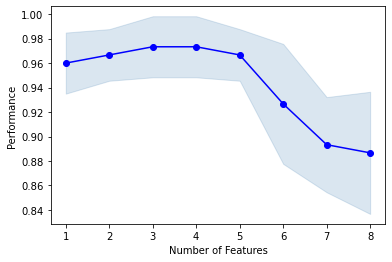

In [4]:
knn = KNeighborsClassifier(n_neighbors=4)
fsel = ffgs.ForwardFeatureGroupSelection(knn, k_features=X.shape[1])
fsel = fsel.fit(X, y)
plot_sfs(fsel.get_metric_dict())

## Custom early stopping function

### Example implementation

To implement early stopping we need to implement a function that takes the metric dictionary (output of `ForwardFeatureGroupSelection.get_metric_dict()`) as an input and returnes a boolean as an output that indicates if to stop (`True`) or proceed (`False`) the feature selection. 
This function will be internally evaluated after every iteration with the metric dictionary as filled at the respective point.

For example a stopping criteria could be to stop if the mean performance does not increases for more than 0.5% (`p`) for 3 (`n`) subsequent iterations.

In [5]:
p = 0.005
n = 3

One way to implement this is as follows (note that `sfs_metrics_to_dataframe` will be available at exection time and can be used inside the costum function).

In [6]:
def early_stop(metrics_dict, p=0.005, n=3, verbosity=0):
    metrics_df = ffgs.sfs_metrics_to_dataframe(metrics_dict)
    metrics_df["perf_change"] = metrics_df["avg_score"].pct_change()
    metrics_df["perf_change_let_p"] = metrics_df["perf_change"] <= p

    metrics_df["perf_change_let_p_n_successive"] = metrics_df["perf_change_let_p"].groupby(metrics_df["perf_change_let_p"].eq(0).cumsum()).cumsum().tolist()
    stop = metrics_df.loc[metrics_df.index[-1], "perf_change_let_p_n_successive"] >= n
    
    if verbosity > 0 and stop:
        print("Stopping criteria met!")
    if verbosity > 1 and stop:
        display(metrics_df[["avg_score", "perf_change", "perf_change_let_p", "perf_change_let_p_n_successive"]])
    return stop

Note that the metrics dictionary will have one more element after every iteration, i.e. after every additionally selected feature.
The following shows the early stopping evaluation process: 

In [7]:
full_metric_dict = fsel.get_metric_dict()

metric_dict_after_iter_i = {}
for i, last_md_key in enumerate(full_metric_dict.keys()):
    print(f"i={i}", end=" - ")
    metric_dict_after_iter_i[last_md_key] = full_metric_dict[last_md_key]
    stop = early_stop(metric_dict_after_iter_i, p=0.005, n=3, verbosity=2)
    #print(f"STOP: {stop}")
    if stop:
        break

i=0 - i=1 - i=2 - i=3 - i=4 - i=5 - Stopping criteria met!


,avg_score,perf_change,perf_change_let_p,perf_change_let_p_n_successive
iter,,,,
1,0.960000,NaN,False,0
2,0.966667,0.006944,False,0
3,0.973333,0.006897,False,0
4,0.973333,0.000000,True,1
5,0.966667,-0.006849,True,2
6,0.926667,-0.041379,True,3


### Useage

As we can see from the outputs and plot the last iterations are not ran anymore. 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished
Features: 1/8[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s finished
Features: 2/8[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s finished
Features: 3/8[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
Features: 4/8[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
Features: 5/8[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 6/8

Stopping early due to custom early stopping criteria.


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Number of Features', ylabel='Performance'>)

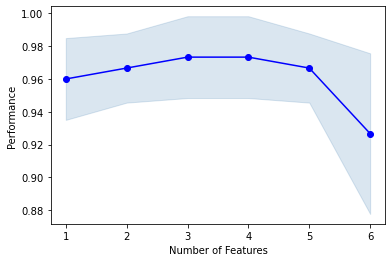

In [8]:
fsel = ffgs.ForwardFeatureGroupSelection(knn, k_features=X.shape[1], verbose=True)
fsel = fsel.fit(X, y, custom_early_stop=early_stop)
plot_sfs(fsel.get_metric_dict())